### Using frangi 

In [1]:
import cv2
import matplotlib.pyplot as plt
from os import listdir
from skimage.filters import frangi
import numpy as np


In [2]:
images = [cv2.imread("all//images//"+f) for f in listdir("all//images")]
grey_images = [cv2.imread("all//images//"+f,cv2.IMREAD_GRAYSCALE) for f in listdir("all//images")]
green_images = [image[..., 1] for image in images]
manual = [cv2.imread("all//manual1//"+f) for f in listdir("all//manual1")]
mask = [cv2.imread("all//mask//"+f) for f in listdir("all//mask")]


In [239]:
frangi_images=[]
for i in range(5):
    frangi_image = frangi(grey_images[2*i])
    binary_frangi_image = (frangi_image * 255).astype(np.uint8)
    binary_frangi_image = cv2.equalizeHist(binary_frangi_image)
    binary_frangi_image = cv2.threshold(binary_frangi_image, 0.5, 1, cv2.THRESH_BINARY)[1]
    new_mask = mask[i]
    image_resized = cv2.resize(binary_frangi_image, (new_mask.shape[1], new_mask.shape[0]))
    masked_image = new_mask.copy()
    masked_image[image_resized == 0] = 0
    kernel_ero = np.ones((2, 2), np.uint8)
    kernel_dil = np.ones((4, 4), np.uint8)
    masked_image = cv2.erode(masked_image,kernel_ero,iterations = 1)
    masked_image = cv2.dilate(masked_image,kernel_dil,iterations = 1)
    frangi_images.append(masked_image)

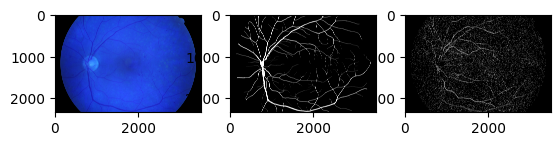

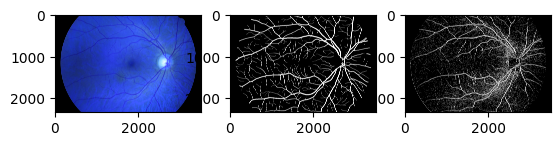

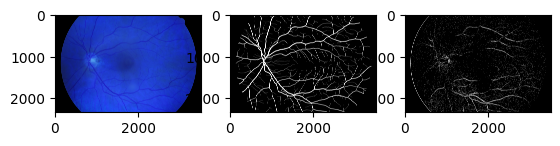

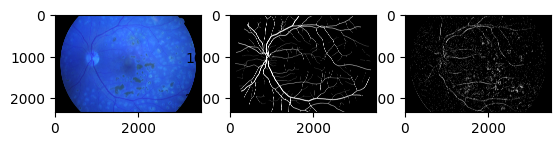

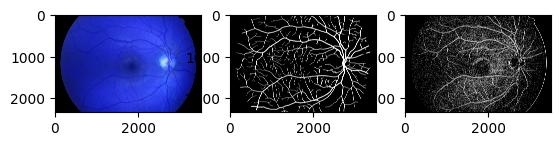

In [241]:
for i in range(5):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(images[2*i])
    plt.subplot(1, 3, 2)
    plt.imshow(manual[2*i])
    plt.subplot(1, 3, 3)
    plt.imshow(frangi_images[i])
    plt.show()

In [243]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from sklearn.metrics import confusion_matrix
from math import sqrt

for i in range(5):
    psnr = compare_psnr(manual[2*i], frangi_images[i])
    conf = confusion_matrix(manual[2*i].flatten(), frangi_images[i].flatten())
    TN, FP, FN, TP = conf.ravel()
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = sqrt(sensitivity * specificity)
    
    print(f"PSNR: {psnr:.2f}, Dokładność: {accuracy:.2f}, Czułość: {sensitivity:.2f}, Swoistość: {specificity:.2f}, Średnia geometryczna czułości i swoistości: {geo_mean_val:.2f}")
    
    

PSNR: 10.54, Dokładność: 0.91, Czułość: 0.24, Swoistość: 0.95, Średnia geometryczna czułości i swoistości: 0.47
PSNR: 9.53, Dokładność: 0.89, Czułość: 0.54, Swoistość: 0.93, Średnia geometryczna czułości i swoistości: 0.71
PSNR: 10.86, Dokładność: 0.92, Czułość: 0.20, Swoistość: 0.98, Średnia geometryczna czułości i swoistości: 0.44
PSNR: 11.39, Dokładność: 0.93, Czułość: 0.20, Swoistość: 0.97, Średnia geometryczna czułości i swoistości: 0.44
PSNR: 8.20, Dokładność: 0.85, Czułość: 0.48, Swoistość: 0.89, Średnia geometryczna czułości i swoistości: 0.66


### Using Logistic Regression

In [3]:
green_images = [image[..., 1] for image in images]
green_manual = [image[..., 1] for image in manual]
green_mask = [image[..., 1] for image in mask]

resized_images = [cv2.resize(image, (3500, 2300)) for image in green_images]
resized_manual = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in manual]
resized_manual = [cv2.resize(image, (3500,2300)) for image in resized_manual]

In [4]:
small_images = []
small_manual=[]

for image in resized_images:
    for i in range(0, len(image), 5):
        for j in range(0, len(image[0]), 5):
            square = [row[j:j+5] for row in image[i:i+5]]
            small_images.append(square)
            
for image in resized_manual:
    for i in range(0, len(image), 5):
        for j in range(0, len(image[0]), 5):
            square = [row[j:j+5] for row in image[i:i+5]]
            small_manual.append(square)
            
small_images = np.array(small_images)
small_manual = np.array(small_manual)
        

In [5]:
small_images_flatten=[]
small_manual_flatten=[]

for i in range(len(small_images)):
    small_images_flatten.append(small_images[i].flatten())


for i in range(len(small_manual)):
    small_manual_flatten.append(small_manual[i].flatten())
    
small_images_flatten = np.array(small_images_flatten)
small_manual_flatten = np.array(small_manual_flatten)

In [11]:
labels=[]

for man in small_manual_flatten:
    if(np.mean(man)>50 and np.var(man)<1000):
        labels.append(1)
    else:
        labels.append(0)
        
print(len(labels))

print(sum(labels)/len(labels))

14490000
0.10234899930986888


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

start = 322000*5
start=322000
X = small_images_flatten[start:]  
y = labels[start:]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = make_pipeline(PolynomialFeatures(degree=2), SelectKBest(score_func=f_classif, k=10), LogisticRegression(max_iter=10))
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu: {:.2f}%".format(accuracy * 100))

# joblib.dump(model, 'model4.pkl')

Dokładność modelu: 89.63%


['model4.pkl']

In [13]:
# import joblib

# m = joblib.load('model.pkl')

outputs = []
for i in range(5):
    test_image = resized_images[i]
    small_test = []

    for i in range(0, len(test_image), 5):
            for j in range(0, len(test_image[0]), 5):
                square = [row[j:j+5] for row in test_image[i:i+5]]
                small_test.append(square)
                
    small_test = np.array(small_test)
    small_test_flatten=[]
    
    for part in small_test:
        small_test_flatten.append(part.flatten())

    small_test_flatten = np.array(small_test_flatten)

    output = model.predict(small_test_flatten)
    output = np.array(output).reshape(460,  700)
    outputs.append(output)

C:\Users\jakub\AppData\Local\Temp\ipykernel_20948\2770030231.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  out = imageio.imread(f"output_{i}.JPG")


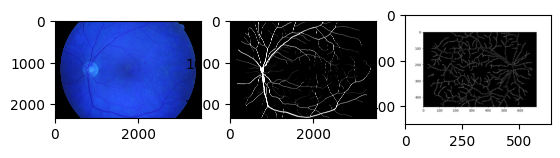

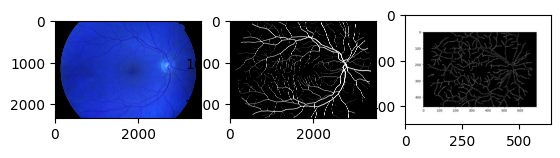

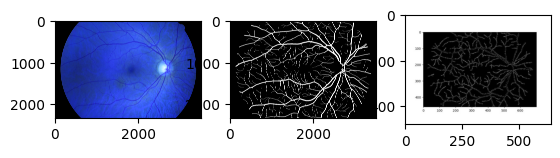

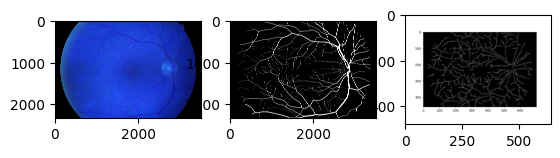

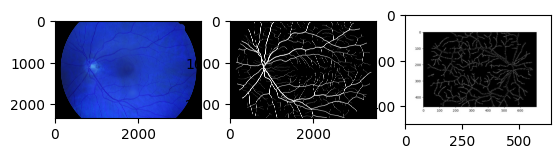

In [33]:
import imageio
outputs4=[]

for i in range(5):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(images[i])
    plt.subplot(1, 3, 2)
    plt.imshow(manual[i])
    plt.subplot(1, 3, 3)
    # plt.imshow(outputs[i],cmap='gray')
    out = imageio.imread(f"output_{i}.JPG")
    plt.imshow(out,cmap='gray')
    outputs4.append(out)
    plt.show()
        

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from sklearn.metrics import confusion_matrix
from math import sqrt

def confusion(matrix_result, matrix_manual):
    tres = 50
    res = np.zeros((2,2))
    for i in range(len(matrix_result)):
        for j in range(len(matrix_result[0])):
            if matrix_result[i][j]>tres and matrix_manual[i][j]>tres:
                res[0][0]+=1
            elif matrix_result[i][j]>tres and matrix_manual[i][j]<tres:
                res[0][1]+=1
            elif matrix_result[i][j]<tres and matrix_manual[i][j]>tres:
                res[1][0]+=1
            else:
                res[1][1]+=1
    return res

for i in range(5):
    man_to_compare = cv2.resize(manual[i], (700, 460))
    man_to_compare = cv2.cvtColor(man_to_compare, cv2.COLOR_BGR2GRAY)
    neuron_output_scaled = (outputs[i] - np.min(outputs[i])) * (255 / (np.max(outputs[i]) - np.min(outputs[i])))
    neuron_output_scaled = neuron_output_scaled.astype(np.uint8)
    psnr = compare_psnr(man_to_compare, neuron_output_scaled)
    c = confusion(neuron_output_scaled,man_to_compare)
    # np.array(conf).shape
    # print(conf.ravel().shape)
    TP, FP, FN, TN = c[0][0],c[0][1],c[1][0],c[1][1]
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = sqrt(sensitivity * specificity)
    
    print(f"PSNR: {psnr:.2f}, Dokładność: {accuracy:.2f}, Czułość: {sensitivity:.2f}, Swoistość: {specificity:.2f}, Średnia geometryczna czułości i swoistości: {geo_mean_val:.2f}")
    
    

Pomiary

PSNR: 10.75, Dokładność: 0.91, Czułość: 0.15, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.37

PSNR: 10.12, Dokładność: 0.89, Czułość: 0.10, Swoistość: 0.95, Średnia geometryczna czułości i swoistości: 0.31

PSNR: 8.92, Dokładność: 0.86, Czułość: 0.09, Swoistość: 0.94, Średnia geometryczna czułości i swoistości: 0.29

PSNR: 10.22, Dokładność: 0.90, Czułość: 0.13, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.35

PSNR: 9.80, Dokładność: 0.89, Czułość: 0.12, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.34


### Using neural network

In [218]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

start = 322000*5

class MyDataset(Dataset):
    def __init__(self):
        self.x = torch.tensor(small_images_flatten[start:], dtype=torch.float32)
        self.y = torch.tensor(labels[start:], dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(25, 25)
        self.ReLu1 = nn.ReLU()
        self.Relu2 = nn.ReLU()
        self.Linear2 = nn.Linear(25, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.Linear1(x)
        x = self.ReLu1(x)
        x = self.Relu2(x)
        x = self.Linear2(x)
        x = self.sigmoid(x)
        return x


def train(_model, _dataloader, _criterion, _optimizer, _epoch, _device, _validation_dataloader):
    epoch_loss = 0
    validation_loss = 0
    total = 0
    tqdm_meter = tqdm(_dataloader, unit=' batches', desc=f'Epoch {_epoch}', leave=False)

    _model.train()

    for _data,_label in tqdm_meter:
        _label = torch.as_tensor(_label)
        _label = _label.to(torch.float32)
        _label = _label.unsqueeze(1)
        _data = _data.to(_device)
        _label = _label.to(_device)
        _optimizer.zero_grad()
        out = _model(_data)
        _loss = _criterion(out, _label)
        epoch_loss = epoch_loss + _loss.item()
        total = total + _data.shape[0]
        _loss.backward()
        _grad_norm = nn.utils.clip_grad_norm_(
            parameters=_model.parameters(),
            max_norm=float('inf') 
        )
        _optimizer.step()
        tqdm_meter.set_postfix(ordered_dict={
            'loss': f'{_loss.item():0.4f}', 'grad norm': _grad_norm
        })
        tqdm_meter.update()
    
    _model.eval()
    tqdm_meter = tqdm(_validation_dataloader, unit=' batches', desc=f'Epoch {_epoch}', leave=False)
    for _data, _label in tqdm_meter:
        _label = _label.to(torch.float32)
        _data = _data.to(_device)
        _label = _label.unsqueeze(1)
        _label = _label.to(_device)
        out = _model(_data)
        _loss = _criterion(out, _label)
        validation_loss = validation_loss + _loss.item()
    
    print(f"Validation loss: {validation_loss}")
    return epoch_loss, validation_loss


cuda
1


Validation loss: 5733.574326783419
2


Validation loss: 5716.9302016198635
3


Validation loss: 5713.882497513667
4


findfont: Font family 'xkcd' not found.                                                                                         
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font f

Validation loss: 5732.757901264355


findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Fo

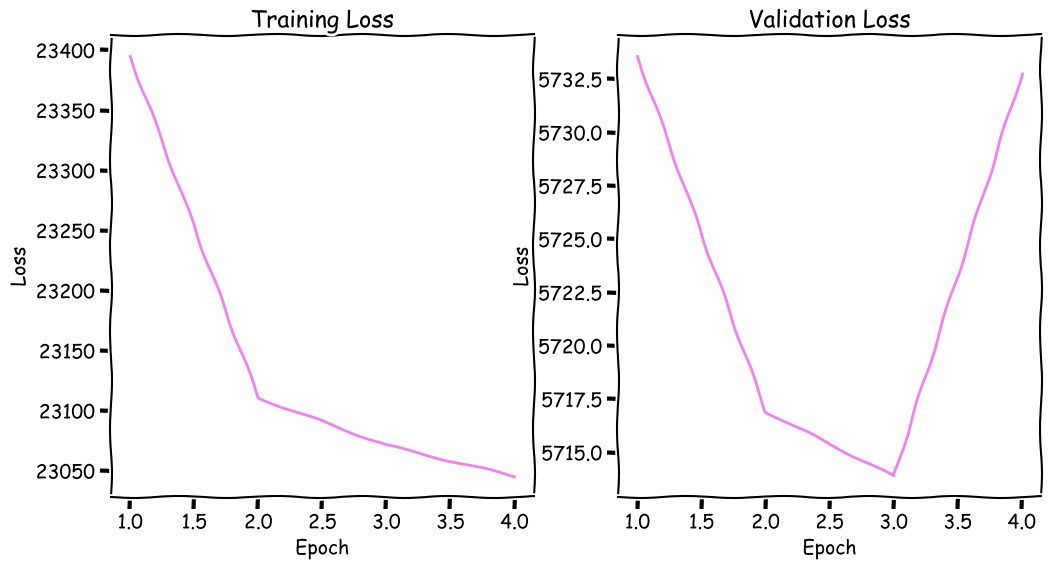

In [219]:
device='cuda'
print(device)
dataset = MyDataset()

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = MyModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 1
losses, val_losses = [], []

while epoch < 5:
    print(epoch)
    train_loss, val_loss = train(model, train_dataloader, criterion, optimizer, epoch, device, val_dataloader)
    losses.append(train_loss)
    val_losses.append(val_loss)
    epoch += 1
    
torch.save(model.state_dict(), "sensowny2.pt")

with plt.xkcd():
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses, color='violet')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss')
    # plt.grid(alpha=0.4, linestyle='--')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, color='violet')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Validation Loss')
    # plt.grid(alpha=0.4, linestyle='--')
    # plt.tight_layout()
    plt.show()

In [226]:
neuron_outputs = []

for i in range(5):
    start = 322000*i
    stop = 322000*(i+1)
    class MyDataset_to_check(Dataset):
        def __init__(self):
            self.x = torch.tensor(small_images_flatten[start:stop], dtype=torch.float32)

        def __len__(self):
            return len(self.x)

        def __getitem__(self, idx):
            return self.x[idx]


    device = 'cpu'
    model = MyModel()
    model.load_state_dict(torch.load('sensowny.pt'))
    model.eval()
    data = MyDataset_to_check()
    data_loader = DataLoader(dataset=data)
    output=[]
    with torch.no_grad(): 
        for x in data_loader:
            x = x.to(device)
            output.append(model(x))
            
    for i in range(len(output)):
        output[i]=output[i][0]
        
    output = np.array(output)
    output = output.reshape(460,700)
    neuron_outputs.append(output)

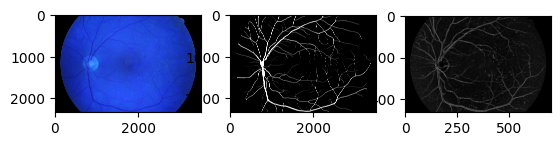

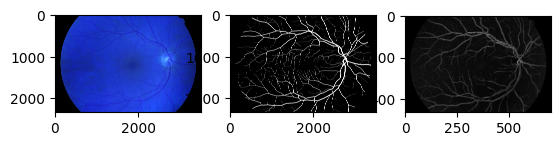

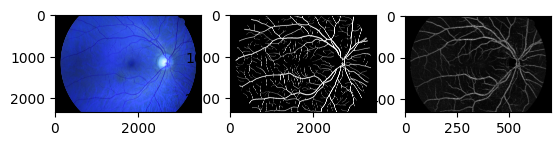

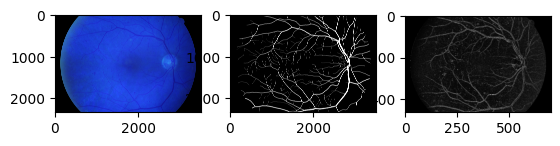

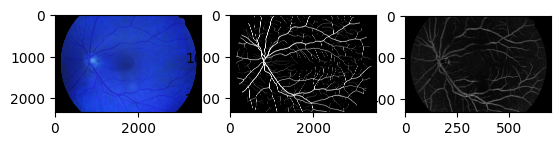

In [227]:
for i in range(5):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(images[i])
    plt.subplot(1, 3, 2)
    plt.imshow(manual[i])
    plt.subplot(1, 3, 3)
    plt.imshow(neuron_outputs[i],cmap='gray')
    plt.show()

In [235]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from sklearn.metrics import confusion_matrix
from math import sqrt

def confusion(matrix_result, matrix_manual):
    tres = 50
    res = np.zeros((2,2))
    for i in range(len(matrix_result)):
        for j in range(len(matrix_result[0])):
            if matrix_result[i][j]>tres and matrix_manual[i][j]>tres:
                res[0][0]+=1
            elif matrix_result[i][j]>tres and matrix_manual[i][j]<tres:
                res[0][1]+=1
            elif matrix_result[i][j]<tres and matrix_manual[i][j]>tres:
                res[1][0]+=1
            else:
                res[1][1]+=1
    return res

for i in range(5):
    man_to_compare = cv2.resize(manual[i], (700, 460))
    man_to_compare = cv2.cvtColor(man_to_compare, cv2.COLOR_BGR2GRAY)
    neuron_output_scaled = (neuron_outputs[i] - np.min(neuron_outputs[i])) * (255 / (np.max(neuron_outputs[i]) - np.min(neuron_outputs[i])))
    neuron_output_scaled = neuron_output_scaled.astype(np.uint8)
    psnr = compare_psnr(man_to_compare, neuron_output_scaled)
    c = confusion(neuron_output_scaled,man_to_compare)
    # np.array(conf).shape
    # print(conf.ravel().shape)
    TP, FP, FN, TN = c[0][0],c[0][1],c[1][0],c[1][1]
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = sqrt(sensitivity * specificity)
    
    print(f"PSNR: {psnr:.2f}, Dokładność: {accuracy:.2f}, Czułość: {sensitivity:.2f}, Swoistość: {specificity:.2f}, Średnia geometryczna czułości i swoistości: {geo_mean_val:.2f}")
    
    

PSNR: 13.86, Dokładność: 0.92, Czułość: 0.36, Swoistość: 0.95, Średnia geometryczna czułości i swoistości: 0.59
PSNR: 12.94, Dokładność: 0.92, Czułość: 0.34, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.57
PSNR: 12.31, Dokładność: 0.92, Czułość: 0.57, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.74
PSNR: 12.84, Dokładność: 0.90, Czułość: 0.38, Swoistość: 0.93, Średnia geometryczna czułości i swoistości: 0.60
PSNR: 12.50, Dokładność: 0.91, Czułość: 0.37, Swoistość: 0.96, Średnia geometryczna czułości i swoistości: 0.60
